In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sns
import math
import os
import tempfile
import matplotlib as mpl
from sklearn.metrics import confusion_matrix



In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#Karpathy 1. fix random seed
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

In [5]:
ATT_FILE_NAME = "FootballPlayerPreparedCleanAttributes.csv"
ONE_HOT_ENCODED_CLASSES_FILE_NAME = "FootballPlayerOneHotEncodedClasses.csv"

In [6]:
att = pd.read_csv(ATT_FILE_NAME)
target = pd.read_csv(ONE_HOT_ENCODED_CLASSES_FILE_NAME)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
att.describe()

,Crossing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Reactions,ShotPower,Stamina,LongShots,Aggression,Positioning,Vision,Composure
count,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000,16122.000000
mean,0.053537,0.064942,0.168294,-0.081373,0.122654,-0.030012,-0.132537,0.002751,0.076091,0.098800,0.125965,0.169170,-0.025506,0.136145,0.043417,0.060219,0.036497
std,0.344606,0.293820,0.268085,0.369549,0.301492,0.364944,0.358826,0.334822,0.282066,0.233806,0.326638,0.324097,0.379027,0.352347,0.349409,0.314939,0.274291
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.195122,-0.139241,0.013699,-0.375000,-0.012048,-0.325301,-0.428571,-0.189189,-0.070423,-0.066667,-0.086420,-0.014493,-0.301205,-0.097561,-0.166667,-0.146341,-0.162162
50%,0.097561,0.088608,0.205479,-0.075000,0.180723,-0.012048,-0.190476,0.054054,0.098592,0.093333,0.160494,0.188406,0.036145,0.170732,0.095238,0.097561,0.054054
75%,0.317073,0.265823,0.342466,0.200000,0.325301,0.253012,0.142857,0.243243,0.267606,0.253333,0.358025,0.391304,0.277108,0.390244,0.285714,0.292683,0.243243
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
target.head()

,"Poor:[46.0, 62.0]","Interm:[63.0, 66.0]","Good:[67.0, 71.0]","Excel:[72.0, 94.0]"
0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0


In [34]:
clases = np.argmax(target.to_numpy(),axis=1)

In [35]:
np.bincount(clases) # contar cuantos elemntos tengo de cada clase en el conjunto de datos

array([4296, 3868, 4353, 3605], dtype=int64)

In [36]:
c1, c2,c3,c4= np.bincount(clases)
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}") #lo mismo de arriba

Total: 16122. C1 4296, c2 3868, c3 4353, c4 3605


In [37]:
X_train,X_rem,y_train,y_rem = train_test_split(att,target,train_size=0.8)
X_valid,X_test,y_valid,y_test = train_test_split(X_rem,y_rem,train_size=0.5)
#80 % train   --- 10% val 10% test

In [38]:
c1, c2,c3,c4= np.bincount(np.argmax(y_train.to_numpy(),axis=1))
total = c1+c2+c3+c4
print(f"Total: {total}. C1 {c1}, c2 {c2}, c3 {c3}, c4 {c4}")

Total: 12897. C1 3458, c2 3103, c3 3475, c4 2861


In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]



In [20]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [21]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [23]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


Observamos el overfit del modelo

In [ ]:
plt.plot(h_100x4x100.history['val_categorical_accuracy'])
plt.plot(h_100x4x100.history['categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy','train_accuracy'], loc='upper left')
plt.show()
# "Loss"

In [ ]:
plt.plot(h_128128.history['val_categorical_accuracy'])
plt.plot(h_nocapas.history['val_categorical_accuracy'])
plt.plot(h_512512.history['val_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['h28128', 'nocapas','512512'], loc='upper left')
plt.show()
# "Loss"


In [46]:
def build_model(n_hidden=1, n_neurons_ocultas=[30], input_shape=(8,), 
                activation_o="relu", optimizer="adam", loss="categorical_crossentropy", metrics=METRICS, 
                activation_s="soft_max", n_neurons_salida=4):     
    model = keras.models.Sequential()     
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    if n_hidden != len(n_neurons_ocultas):
        print("error, tamaño de la lista de n_neuronas no corresponde al umero de capas")
        return -1
    for layer in range(n_hidden):         
        model.add(keras.layers.Dense(n_neurons_ocultas[layer], activation="relu"))     
  
    model.add(keras.layers.Dense(n_neurons_salida, activation=activation_s))  
    model.compile(optimizer=optimizer,   
              loss=loss,
              metrics=metrics)    
    return model

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 10)                180       
                                                                 
 dense_85 (Dense)            (None, 10)                110       
                                                                 
 dense_86 (Dense)            (None, 10)                110       
                                                                 
 dense_87 (Dense)            (None, 4)                 44        
                                                                 
Total params: 444
Trainable params: 444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 2s 15ms/step - loss: 1.3665 - tp: 435.0000 - fp: 31.0000 - tn: 77351.0000 - fn: 25359.0000 - accuracy: 0.7539 - precision: 0.9335 - re

51/51 [==============================] - 0s 2ms/step - loss: 1.3414 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38691.0000 - fn: 12897.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6041 - prc: 0.3929 - val_loss: 1.3476 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4839.0000 - val_fn: 1613.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5878 - val_prc: 0.3736
Epoch 18/100
51/51 [==============================] - 0s 3ms/step - loss: 1.3413 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 38691.0000 - fn: 12897.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6043 - prc: 0.3932 - val_loss: 1.3475 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4839.0000 - val_fn: 1613.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5878 - val_prc: 0.3739
Epoch 19/100
51/51 [==============================] - 0s 2ms/step - loss: 1.3412 - tp: 0.0000e+00 - fp: 0

Epoch 36/100
51/51 [==============================] - 0s 3ms/step - loss: 1.3044 - tp: 73.0000 - fp: 1.0000 - tn: 38690.0000 - fn: 12824.0000 - accuracy: 0.7514 - precision: 0.9865 - recall: 0.0057 - auc: 0.6410 - prc: 0.4405 - val_loss: 1.3117 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 4839.0000 - val_fn: 1603.0000 - val_accuracy: 0.7515 - val_precision: 1.0000 - val_recall: 0.0062 - val_auc: 0.6296 - val_prc: 0.4208
Epoch 37/100
51/51 [==============================] - 0s 3ms/step - loss: 1.3027 - tp: 86.0000 - fp: 1.0000 - tn: 38690.0000 - fn: 12811.0000 - accuracy: 0.7516 - precision: 0.9885 - recall: 0.0067 - auc: 0.6427 - prc: 0.4422 - val_loss: 1.3102 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 4839.0000 - val_fn: 1603.0000 - val_accuracy: 0.7515 - val_precision: 1.0000 - val_recall: 0.0062 - val_auc: 0.6311 - val_prc: 0.4221
Epoch 38/100
51/51 [==============================] - 0s 3ms/step - loss: 1.3012 - tp: 92.0000 - fp: 1.0000 - tn: 38690.0000 - fn: 12805.0000 - 

51/51 [==============================] - 0s 2ms/step - loss: 1.2895 - tp: 226.0000 - fp: 3.0000 - tn: 38688.0000 - fn: 12671.0000 - accuracy: 0.7543 - precision: 0.9869 - recall: 0.0175 - auc: 0.6553 - prc: 0.4538 - val_loss: 1.2984 - val_tp: 18.0000 - val_fp: 1.0000 - val_tn: 4838.0000 - val_fn: 1595.0000 - val_accuracy: 0.7526 - val_precision: 0.9474 - val_recall: 0.0112 - val_auc: 0.6439 - val_prc: 0.4328
Epoch 56/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2895 - tp: 227.0000 - fp: 3.0000 - tn: 38688.0000 - fn: 12670.0000 - accuracy: 0.7543 - precision: 0.9870 - recall: 0.0176 - auc: 0.6553 - prc: 0.4538 - val_loss: 1.2984 - val_tp: 18.0000 - val_fp: 1.0000 - val_tn: 4838.0000 - val_fn: 1595.0000 - val_accuracy: 0.7526 - val_precision: 0.9474 - val_recall: 0.0112 - val_auc: 0.6440 - val_prc: 0.4329
Epoch 57/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2894 - tp: 228.0000 - fp: 3.0000 - tn: 38688.0000 - fn: 12669.0000 - accuracy: 0.7544 -

51/51 [==============================] - 0s 3ms/step - loss: 1.2524 - tp: 1056.0000 - fp: 75.0000 - tn: 38616.0000 - fn: 11841.0000 - accuracy: 0.7690 - precision: 0.9337 - recall: 0.0819 - auc: 0.6919 - prc: 0.4802 - val_loss: 1.2623 - val_tp: 121.0000 - val_fp: 13.0000 - val_tn: 4826.0000 - val_fn: 1492.0000 - val_accuracy: 0.7667 - val_precision: 0.9030 - val_recall: 0.0750 - val_auc: 0.6810 - val_prc: 0.4594
Epoch 75/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2501 - tp: 1087.0000 - fp: 96.0000 - tn: 38595.0000 - fn: 11810.0000 - accuracy: 0.7692 - precision: 0.9189 - recall: 0.0843 - auc: 0.6941 - prc: 0.4817 - val_loss: 1.2601 - val_tp: 125.0000 - val_fp: 14.0000 - val_tn: 4825.0000 - val_fn: 1488.0000 - val_accuracy: 0.7672 - val_precision: 0.8993 - val_recall: 0.0775 - val_auc: 0.6834 - val_prc: 0.4609
Epoch 76/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2478 - tp: 1137.0000 - fp: 109.0000 - tn: 38582.0000 - fn: 11760.0000 - accurac

51/51 [==============================] - 0s 2ms/step - loss: 1.2161 - tp: 1742.0000 - fp: 307.0000 - tn: 38384.0000 - fn: 11155.0000 - accuracy: 0.7778 - precision: 0.8502 - recall: 0.1351 - auc: 0.7231 - prc: 0.5016 - val_loss: 1.2281 - val_tp: 211.0000 - val_fp: 41.0000 - val_tn: 4798.0000 - val_fn: 1402.0000 - val_accuracy: 0.7763 - val_precision: 0.8373 - val_recall: 0.1308 - val_auc: 0.7124 - val_prc: 0.4814
Epoch 94/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2147 - tp: 1763.0000 - fp: 318.0000 - tn: 38373.0000 - fn: 11134.0000 - accuracy: 0.7780 - precision: 0.8472 - recall: 0.1367 - auc: 0.7242 - prc: 0.5024 - val_loss: 1.2268 - val_tp: 212.0000 - val_fp: 41.0000 - val_tn: 4798.0000 - val_fn: 1401.0000 - val_accuracy: 0.7765 - val_precision: 0.8379 - val_recall: 0.1314 - val_auc: 0.7132 - val_prc: 0.4820
Epoch 95/100
51/51 [==============================] - 0s 2ms/step - loss: 1.2134 - tp: 1784.0000 - fp: 333.0000 - tn: 38358.0000 - fn: 11113.0000 - accur

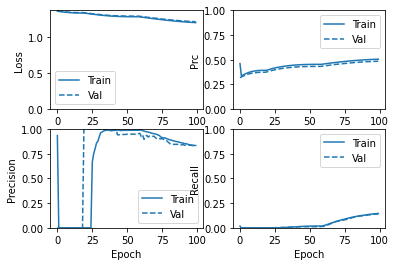

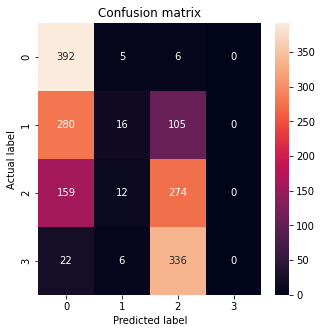

In [54]:
  
first_decay_steps = 1000 
initial_learning_rate = 1e-3
#lr_decayed_fn = (   tf.keras.optimizers.schedules.CosineDecayRestarts(       initial_learning_rate,       first_decay_steps))
optimizer = keras.optimizers.SGD(learning_rate=1e-3) 
h_100x4x100 = build_model(3, [10,10,10], (17,), "relu", optimizer, "categorical_crossentropy", METRICS, "softmax", 4)

BATCH_SIZE=256
EPOCHS=100

h_100x4x100.summary()
results_fit= h_100x4x100.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_test,y_test), batch_size=BATCH_SIZE)


results_evaluate = h_100x4x100.evaluate(X_train,y_train,batch_size=BATCH_SIZE)

train_predictions_baseline = h_100x4x100.predict(X_train, batch_size=BATCH_SIZE)
test_predictions_baseline = h_100x4x100.predict(X_test, batch_size=BATCH_SIZE)


plot_metrics(results_fit)


for name, value in zip(h_100x4x100.metrics_names, results_evaluate):
  print(name, ': ', value)
print()

plot_cm(np.argmax(y_test.to_numpy(),axis=1), test_predictions_baseline.argmax(axis=1))